# Group project - Computational Game Theory

# Playing rock paper scissors game

In this game 2 agents compete with each other in a rock paper scissors game.
Both players can heve their own learning algorithms assigned to make comparing different learners possible.
This is done in an abstract way to make testing alternate situations easy.

## TOC
- Group info
- Important note
- Required imports
- Storing and loading variables
- Code to represent the players and games
   - The WolfMatchingRPCPlayer class
   - The PhcRPCPlayer class
   - The RPCGame class
   - The average_games function
- Playing the game (WoLF)
- Playing the game (HCP)
- Plotting averages
- Plotting single run

## Student info
| Name     | Student number                        | Email address                               |
| :---     | :---                          | :---                                |
| Alexis Francois Verdoodt | _ | _ |
| Lennert Bontinck | 568702 | [lennert.bontinck@vub.be](mailto:lennert.bontinck@vub.be) |
| Sofyan Ajridi | _ | _ |
| Wolf De Wulf | 546395 | [wolf.de.wulf@vub.be](mailto:wolf.de.wulf@vub.be) |

## Important note
In some codeblocks, the code might refer to variables from previous sections, in order to get accurate results code must be run top to bottom without skipping. The result of some lengthy processes is saved to a Pickle file to make the results available for reuse later.

## Required imports
All imports required for this notebook.

In [1]:
# General imports
import numpy as np
import random
import statistics as stats
import math
from scipy import stats as sstats

# Allow for deep copying instead of python references (default)
import copy

# Plotting imports
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'svg'}

# Library to save vars to files
import pickle

## Storing and loading variables
Improves reproducibility and allows for using previous results of lengthy processes.

In [2]:
def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
    
#-------------------------

#save to file example
#save_var_to_file("folder/name", var_to_save)
    
#open from file example
#get_var_from_file = get_var_from_file("folder/name")

## Code to represent the players and games
Let's start by making a way of representing the games and playing them in an abstract manner.

### The WolfRPCPlayer class
A class for defining a RPC player according to the WoLF algorithm.

In [19]:
class WolfRPCPlayer:
    """
    A class used to represent a matching pennies player using the WoLF algorithm.
    Has no notion of state since there is only 1 state.
    Makes use of a time-varrying alpha and delta thus it's not needed to specify these.

    ...

    Attributes
    ----------
    q_values : list
        List containing the player's current q values estimate for rock (0), paper (1) and scissors (1).
    
    policy_probabilities : list
        List containing the player's current policy probabilities estimate for rock (0), paper (1) and scissors (1).
    
    average_policy_probabilities : list
        List containing the player's current average policy probabilities estimate for rock (0), paper (1) and scissors (1).
    
    gamma : decimal
        Decimal representing the discount factor.
    
    actions : list
        List containing the three actions available to the player:  rock (0), paper (1) and scissors (1).
    
    state_count : int
        Integer that represents the current state count. Since there is only 1 state this represents the iteration count.
    
    Methods
    -------
    choose_action()
        Chooses an action based on the current policy probabilities estimate for  rock (0), paper (1) and scissors (1).
        There's a 0.05 probability of chosing a random action for exploration.
        Returns the chosen action, which is thus represented as an integer.
    
    increment_state_count()
        Increments the state count by one. Since there is only 1 state in this application this corresponds with the iteration count.
    
    update_q_value_for_action(action, received_reward)
        Updates the estimated q-value using the new given reward.
        
    update_average_policy_probabilities(chosen_action, won)
        Updates list containing the player's current average policy probabilities estimate for heads  rock (0), paper (1) and scissors (1).
        Provide fixed first action and wether agent won (making averaging more useful).
        
    update_policy_probabilities(chosen_action, won)
        Updates list containing the player's current policy probabilities estimate for  rock (0), paper (1) and scissors (1).
        Provide fixed first action and wether agent won (making averaging more useful).
    
    Helper Methods
    -------
    player_is_winning()
        Returns a bool specifying if a user is winning or not
        
    timed_alpha()
        Returns the current alpha value to be used (for q-value calculations)
        
    timed_winning_delta()
        Returns the current winning delta to be used for setting the average policy probabilities.
        AKA winning learning rate        
        
    timed_losing_delta()
        Returns the current losing delta to be used for setting the average policy probabilities.
        AKA losing learning rate
    """
    def __init__(self, initial_q_value, initial_policy_probabilities, gamma):
        """
        Parameters
        ----------
        initial_q_value : decimal
            Decimal representing the initial value of the q_values.
        initial_policy_probabilities : decimal
            Decimal representing the initial value of the policy_probabilities and average_policy_probabilities.
        gamma : decimal
            Decimal representing alpha for updating gamma value estimations.
        """
        self.q_values = [initial_q_value]*3
        self.policy_probabilities = [initial_policy_probabilities]*3
        self.average_policy_probabilities = [initial_policy_probabilities]*3
        self.gamma = gamma
        self.actions = [i for i in range(3)] # Rock (0) Paper(1) Scissor(2)
        self.state_count = 0

        
        
        
        
        
        
    def choose_action(self):       
        # give room for some exploration (e.g. stuck in an extreme)
        if  random.random() < 0.05:
            return random.choice(self.actions)
        
        # generate cumulative probabilities
        cum_probs = np.cumsum(self.policy_probabilities)
        
        # chose an action for the cumulative probs
        rnd = random.random()
        for idx in range(len(cum_probs)):
            if (rnd < cum_probs[idx]):
                return idx
        
        
    def increment_state_count(self):
        self.state_count += 1
        
        
    def update_q_value_for_action(self, action, received_reward):
        crt_alpha = self.timed_alpha()
        self.q_values[action] = ((1-crt_alpha) * self.q_values[action]) + crt_alpha * (received_reward + self.gamma * np.max(self.q_values))
                
        
    def update_average_policy_probabilities(self, chosen_action, won):
        c = self.state_count
        
        if c == 1: # just save first measure
            for action in self.actions:
                if won:
                    self.average_policy_probabilities[action] = 1 if action == chosen_action else 0
                else:
                    self.average_policy_probabilities[action] = 1/2 if action != chosen_action else 0
        else:
            for action in self.actions:
                polprob = self.policy_probabilities[action]
                avgpolprob = self.average_policy_probabilities[action]
                self.average_policy_probabilities[action] += (1/c)*(polprob-avgpolprob)
    
    
    def update_policy_probabilities(self, chosen_action, won):
        if self.state_count == 1: # just save first measure
            for action in self.actions:
                if won:
                    self.average_policy_probabilities[action] = 1 if action == chosen_action else 0
                else:
                    self.average_policy_probabilities[action] = 1/2 if action != chosen_action else 0
        else:
            #determine delta
            delta = self.timed_winning_delta() if self.player_is_winning() else self.timed_losing_delta()
            
            #determine 1 max q-value
            max_action = np.argmax(self.q_values)
            
            for action in self.actions:
                if action == max_action:
                    self.policy_probabilities[action] = min(1.0,  self.policy_probabilities[action] + delta)
                else: #devide losing over 2 from the 3 actions
                    self.policy_probabilities[action] = max(0.0,  self.policy_probabilities[action] - (delta/2))

        
        
        
        
        
        
    def player_is_winning(self):
        policy_sum = 0
        avg_policy_sum = 0
        for action in self.actions:
            policy_sum += self.policy_probabilities[action] * self.q_values[action]
            avg_policy_sum += self.average_policy_probabilities[action] * self.q_values[action]
            
        return policy_sum > avg_policy_sum
        
    def timed_alpha(self):
        return 1 / (100 + (self.state_count/10000))
    
    def timed_winning_delta(self): 
        return 1 / (20000 + self.state_count)
    
    def timed_losing_delta(self): 
        return 2 / (20000 + self.state_count)

### The PHCRPCPlayer class - TODO
A class for defining a RPC player according to the PHC algorithm.
Some of the WoLF specific functions will just be dummy functions

In [17]:
class PhcMatchingPenniesPlayer:
    """
    A class used to represent a matching pennies player using the PHC algorithm.
    Has no notion of state since there is only 1 state.
    Has no notion of an average policy thus dummy functions will be used.
    Makes use of a time-varrying alpha and delta thus it's not needed to specify these.

    ...

    Attributes
    ----------
    q_values : list
        List containing the player's current q values estimate for heads (0) and tail (1).
    
    policy_probabilities : list
        List containing the player's current policy probabilities estimate for heads (0) and tail (1).
    
    average_policy_probabilities : list
        Dummy functions.
    
    gamma : decimal
        Decimal representing the discount factor.
    
    actions : list
        List containing both actions available to the player: heads (0) and tail (1).
    
    delta : decimal
        Decimal representing the delta if fixed delta is used
    
    alpha : decimal
        Decimal representing the alpha if fixed alpha is used
    
    uses_time_varying : bool
        Bool specifying whether or not time-varying alpha and delta is used.
    
    state_count : int
        Integer that represents the current state count. Since there is only 1 state this represents the iteration count.
    
    Methods
    -------
    choose_action()
        Chooses an action based on the current policy probabilities estimate for heads (0) and tail (1).
        There's a 0.05 probability of chosing a random action for exploration.
        Returns the chosen action, which is thus represented as an integer.
    
    increment_state_count()
        Increments the state count by one. Since there is only 1 state in this application this corresponds with the iteration count.
    
    update_q_value_for_action(action, received_reward)
        Updates the estimated q-value using the new given reward.
        
    update_average_policy_probabilities(fixed_first_action)
        Dummy function.
        
    update_policy_probabilities(fixed_first_action)
        Updates list containing the player's current policy probabilities estimate for heads (0) and tail (1).
        Provide fixed value for first value (making averaging more useful).
    
    Helper Methods
    -------
    timed_alpha()
        Returns the current alpha value to be used (for q-value calculations)
        
    timed_delta()
        Returns the current delta to be used for setting the estimated current policy probabilities.
        AKA learning rate       
    """
    def __init__(self, initial_q_value, initial_policy_probabilities, gamma,
                 delta, alpha, uses_time_varying):
        """
        Parameters
        ----------
        initial_q_value : decimal
            Decimal representing the initial value of the q_values.
        initial_policy_probabilities : decimal
            Decimal representing the initial value of the policy_probabilities and average_policy_probabilities.
        gamma : decimal
            Decimal representing alpha for updating gamma value estimations.
        """
        self.q_values = [initial_q_value]*2
        self.policy_probabilities = [initial_policy_probabilities, initial_policy_probabilities]
        self.average_policy_probabilities = [initial_policy_probabilities, initial_policy_probabilities]
        self.gamma = gamma
        self.delta = delta
        self.alpha = alpha
        self.uses_time_varying = uses_time_varying
        self.actions = [i for i in range(2)]
        self.state_count = 0

        
        
        
        
        
        
    def choose_action(self):       
        # give room for some exploration (e.g. stuck in an extreme)
        if  random.random() < 0.05:
            return random.choice(self.actions)
        
        # generate cumulative probabilities
        cum_probs = np.cumsum(self.policy_probabilities)
        
        # chose an action for the cumulative probs
        rnd = random.random()
        for idx in range(len(cum_probs)):
            if (rnd < cum_probs[idx]):
                return idx
        
        
    def increment_state_count(self):
        self.state_count += 1
        
        
    def update_q_value_for_action(self, action, received_reward):
        crt_alpha = self.timed_alpha() if self.uses_time_varying else self.alpha
        self.q_values[action] = ((1-crt_alpha) * self.q_values[action]) + crt_alpha * (received_reward + self.gamma * np.max(self.q_values))
                
        
    def update_average_policy_probabilities(self, fixed_first_action):
        return None
    
    
    def update_policy_probabilities(self, fixed_first_action):
        if self.state_count == 1: # just save first measure
            for action in self.actions:
                self.policy_probabilities[action] = 1 if action == fixed_first_action else 0
        else:
            #determine delta
            delta = self.timed_delta() if self.uses_time_varying else self.delta
            
            #determine 1 max q-value
            max_action = np.argmax(self.q_values)
            
            for action in self.actions:
                if action == max_action:
                    self.policy_probabilities[action] = min(1.0,  self.policy_probabilities[action] + delta)
                else:
                    self.policy_probabilities[action] = max(0.0,  self.policy_probabilities[action] - delta)

        
        
        
        
        
        
    def timed_alpha(self):
        return 1 / (100 + (self.state_count/10000))
    
    def timed_delta(self): 
        return 1 / (20000 + self.state_count)

### The RPCGame class
This game does't require the notion of states since the results are indepent of a given state. Thus the transition function can simply return the initial start state for every iteration.

In [16]:
class RPCGame:
    """
    A class used to represent a RPC game.
    Has no notion of state since there is only 1 state.

    ...

    Attributes
    ----------
    players : list
        List containing all (3) players for the game.
        
    
    ----------
    payoff_matrix : list
        represents payoff matrix w.r.t. player 1.
    
    Methods
    -------
    play_game(iterations)
        Plays the game for the given amount of iterations.
        Returns a list containing the policy probabilities for player 1 playing rock (0) and paper (1) over time.
    """
    def __init__(self, players):
        """
        Parameters
        ----------
        players : list
            List containing all (3) players for the game.
        """
        self.players = players
        self.payoff_matrix = [[0, -1, 1],
                              [1, 0, -1],
                              [-1, 1, 0]]
        
        
        
        
        
    def play_game(self, iterations):
        results = [[0, 0] for _ in range(iterations)] #probs rock, probs paper from player 1
        
        # force initial value to make averaging more usefull
        fixed_first_move_player_1 = 0 #rock
        fixed_first_move_player_1_won = True
        fixed_first_move_player_2 = 3 #scissor
        fixed_first_move_player_2_won = False
        
        # determine player moves
        for iteration in range(iterations):
            player1_move = self.players[0].choose_action()
            player2_move = self.players[1].choose_action()
            
            # add to state count
            self.players[0].increment_state_count()
            self.players[1].increment_state_count()
            
            # calculate corresponding reward and update q-value
            reward = self.payoff_matrix[player1_move][player2_move]
            self.players[0].update_q_value_for_action(player1_move, reward)
            self.players[1].update_q_value_for_action(player2_move, -reward)
            # update estimate of average policy
            self.players[0].update_average_policy_probabilities(fixed_first_move_player_1, fixed_first_move_player_1_won)
            self.players[1].update_average_policy_probabilities(fixed_first_move_player_2, fixed_first_move_player_2_won)
            # update policy
            self.players[0].update_policy_probabilities(fixed_first_move_player_1, fixed_first_move_player_1_won)
            self.players[1].update_policy_probabilities(fixed_first_move_player_2, fixed_first_move_player_2_won)
            # save result
            results[iteration][0] = copy.deepcopy(self.players[0].policy_probabilities[0])
            results[iteration][1] = copy.deepcopy(self.players[0].policy_probabilities[1])
                
        return results

### The average_games function

In [5]:
def average_games(game, iterations, trials):
    results = [[0]*iterations for _ in range(trials)] 
    for trial in range(trials):
        copied_game = copy.deepcopy(game)
        results[trial] = copied_game.play_game(iterations)
    return results
        

## Playing the game (WoLF)

In [20]:
initial_q_value = 0
initial_policy_probabilities = 1/3
gamma = 0.8
iterations = 1000000
averaging_amount = 1

player1 = WolfRPCPlayer(initial_q_value, initial_policy_probabilities, gamma)
player2 = WolfRPCPlayer(initial_q_value, initial_policy_probabilities, gamma)
players = [player1, player2]

game = RPCGame(players)

results = average_games(game, iterations, averaging_amount)
save_var_to_file("RPC/wolf_result", results)

## Playing the game (PHC | time-varying) - TODO

In [ ]:
initial_q_value = 0
initial_policy_probabilities = 1/2
gamma = 0.8
delta = 0 #not used -> time-varying
alpha = 0 #not used -> time-varying
uses_time_varying = True
iterations = 1000000
averaging_amount = 30

player1 = PhcMatchingPenniesPlayer(initial_q_value, initial_policy_probabilities, gamma, delta, alpha, uses_time_varying)
player2 = PhcMatchingPenniesPlayer(initial_q_value, initial_policy_probabilities, gamma, delta, alpha, uses_time_varying)
players = [player1, player2]

game = MatchingPenniesGame(players)

results = average_games(game, iterations, averaging_amount)
save_var_to_file("RPC/phc_result_time_varying", results)

## Plotting averages

In [ ]:
# get the results
results = [["WoLF-PHC", get_var_from_file("RPC/wolf_result")]]
           #["PHC with decay", get_var_from_file("RPC/phc_result_time_varying")]

colors = ["blue",
         "orange"]

error_colors = ["orange",
                "blue"]


# --------------------------------------------------------------------------
color_idx = 0
for result in results:
    # average results over trials
    result_data = result[1]
    result_data = [np.array(x) for x in result_data]
    average_result_data_over_all_trials = [np.mean(x) for x in zip(*result_data)]
    
    #determine iterations and averaging amount (trials)
    iterations = len(average_result_data_over_all_trials)
    averaging_amount = len(result_data)l
    
    # plot
    x = np.arange(0, iterations, 1)
    y = average_result_data_over_all_trials
    plt.plot(x, y,
             "-",
             label=result[0],
             color=colors[color_idx])
    
    color_idx += 1

        
plt.legend(loc="lower right")

plt.ylim(0, 1)

plt.xlabel('Pr(Rock)')
plt.ylabel('Pr(Heads)')
plt.title('Probability of playing head over time\n' + str(iterations) + " iterations, " + str(averaging_amount) + " runs")

plt.savefig("graphs/RPC/rpc.png", dpi=300, bbox_inches='tight')
plt.show()

# --------------------------------------------------------------------------
color_idx = 0
for result in results:
    # average results over trials
    result_data = result[1]
    result_data = [np.array(x) for x in result_data]
    average_result_data_over_all_trials = [np.mean(x) for x in zip(*result_data)]
    
    #determine iterations and averaging amount (trials)
    iterations = len(average_result_data_over_all_trials)
    averaging_amount = len(result_data)
    
    # plot
    x = np.arange(0, iterations, 1)
    y = average_result_data_over_all_trials
    plt.plot(x, y,
             "-",
             label=result[0],
             color=colors[color_idx])
           
    error = [sstats.sem(k) for k in zip(*result_data)]
    plt.errorbar(x, y, yerr=error, errorevery=50000, color=colors[color_idx], alpha=1, ecolor=error_colors[color_idx], capsize=3, )
    
    color_idx += 1

        
plt.legend(loc="lower right")

plt.ylim(0, 1)

plt.xlabel('Iterations')
plt.ylabel('Pr(Heads)')
plt.title('Probability of playing head over time\n' + str(iterations) + " iterations, " + str(averaging_amount) + " runs")

plt.savefig("graphs/RPC/rpc_with_error.png", dpi=300, bbox_inches='tight')
plt.show()

## Plotting single run

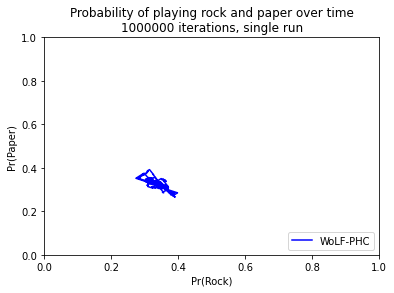

In [25]:
# get the results
results = [["WoLF-PHC", get_var_from_file("RPC/wolf_result")]]
           #["PHC with decay", get_var_from_file("RPC/phc_result_time_varying")]]

colors = ["blue",
         "orange"]


# --------------------------------------------------------------------------
color_idx = 0
for result in results:
    # average results over trials
    result_data = result[1][0]
    result_data_rock = [data[0] for data in result_data]
    result_data_paper = [data[1] for data in result_data]
    
    #determine iterations
    iterations = len(result_data)
    
    # plot
    x = result_data_rock
    y = result_data_paper
    plt.plot(x, y,
             "-",
             label=result[0],
             color=colors[color_idx])
    
    color_idx += 1

        
plt.legend(loc="lower right")

plt.ylim(0, 1)
plt.xlim(0, 1)

plt.xlabel('Pr(Rock)')
plt.ylabel('Pr(Paper)')
plt.title('Probability of playing rock and paper over time\n' + str(iterations) + " iterations, single run")

plt.savefig("graphs/RPC/rpc_single.png", dpi=300, bbox_inches='tight')
plt.show()